In [ ]:
!pip install -q kaggle

# download data set & preparation

In [ ]:
import os
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c ss3-nlp-cmsk-chatbot

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                  8KB  2023-02-01 12:22:51           7259        236  1.0              
amaanansari09/top-100-songs                                        Top 100 songs                                     6KB  2023-02-16 18:55:35           1421         52  1.0              
datascientistanna/customers-dataset                                Shop Customer Data                               23KB  2023-02-07 18:42:21           5804        137  1.0              
thede

In [ ]:
!unzip /content/ss3-nlp-cmsk-chatbot.zip

Archive:  /content/ss3-nlp-cmsk-chatbot.zip
replace context/1345136.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import Pythaynlp

In [ ]:
!pip install -q pythainlp
!pip install -q stop_words

In [ ]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import thai_words
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

In [ ]:
from nltk.corpus import wordnet

In [ ]:
import nltk
# dowload some package from wordnet
nltk.download('wordnet')
nltk.download('word')
nltk.download('omw-1.4')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading word: Package 'word' not found in index
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def split_word(text, remove_stop_word=False):
  tokens = word_tokenize(text, engine='newmm') # newmm is ditionary cutting
  # Remove stop words ภาษาไทย และภาษาอังกฤษ
  if remove_stop_word:
    tokens = [i for i in tokens if not i in th_stop and not i in en_stop]
  # หารากศัพท์ภาษาไทย และภาษาอังกฤษ
  # English
  tokens = [p_stemmer.stem(i) for i in tokens]
  
  # Thai
  tokens_temp=[]
  for i in tokens:
      w_syn = wordnet.synsets(i)
      if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
          tokens_temp.append(w_syn[0].lemma_names('tha')[0])
      else:
          tokens_temp.append(i)
  
  tokens = tokens_temp

  # ลบตัวเลข
  tokens = [i for i in tokens if not i.isnumeric()]
  # ลบช่องว่าง
  tokens = [i for i in tokens if not ' ' in i]
  return tokens

In [ ]:
import re
import string

def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    return msg

In [ ]:
txt = "ใครเป็นผู้ออกตราสารหนี้ภาคเอกชน ไร้ใบตราสาร"
cleaned = clean_msg(txt)
splited = split_word(cleaned, remove_stop_word=False)
print('clean text: ', cleaned)
print('split_word: ', splited)

clean text:  ใครเป็นผู้ออกตราสารหนี้ภาคเอกชน ไร้ใบตราสาร
split_word:  ['ใคร', 'เป็น', 'ผู้', 'ออก', 'ตราสาร', 'หนี้', 'ภาคเอกชน', 'ไร้', 'ใบ', 'ตราสาร']


# Explor Data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Classify_testfile - Classify_testfile.csv')

In [ ]:
df

,question,mode
0,ทำยังไงให้ได้รางวัลโนเบล,chitchat
1,ขี้เกียจอาบน้ำจัง นอนเลยได้ไหม,chitchat
2,เรียนอย่างแบด แซดอย่างบ่อยทำไงดี,chitchat
3,ปลาตัวเล็กอร่อยจังเล้ยย!!!,chitchat
4,ช่่วงนี้มีหนังอะไรน่าดู,chitchat
...,...,...
795,กลยุทธ์ที่เลือกกองทุนแบบ Passive เป็นส่วนใหญ่ ...,qa
796,ปัจจัยที่ส่งผลต่อผลตอบแทนด้านความสามารถในการชำ...,qa
797,ธุรกรรมซื้อขายปกติ คืออะไร,qa
798,ใครเป็นผู้ออกตราสารหนี้ภาคเอกชน ไร้ใบตราสาร,qa


# Encode Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df["labels"] = labelencoder.fit_transform(df["mode"])
df["labels"] = labelencoder.fit_transform(df["mode"])

# train test split

In [ ]:
x = df['question']
y = df['labels']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.5, shuffle=True)

In [ ]:
print('len train:', len(X_train))
print('len test: ', len(X_test))

len train: 400
len test:  400


# Feature Extraction

##TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pythainlp.tokenize import word_tokenize
# สร้าง TFidf โดยจะมีการทำ tokenize และมีการแบ่งคำอยู่ในช่วง 2 token (คำติดกัน)
ws_tfidf = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), sublinear_tf=True)
# เอา train, test มา extract
ws_vec = ws_tfidf.fit_transform(X_train)
ws_vec_test = ws_tfidf.transform(X_test)

In [ ]:
print(ws_vec[:10])

In [ ]:
print(ws_vec.toarray())

[[0.18256607 0.         0.         ... 0.         0.         0.        ]
 [0.12384886 0.         0.         ... 0.         0.         0.        ]
 [0.12643719 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07238201 0.         0.         ... 0.         0.         0.        ]
 [0.06584218 0.         0.         ... 0.         0.         0.        ]]


#Modeling

## Ensemble

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
# ใช้ ensemble ในการ classify
estimators = [
    ('rf', RandomForestClassifier(n_estimators=2, random_state=42)),
    ('svc',LinearSVC(random_state=42)),
    ('knn',KNeighborsClassifier(n_neighbors=2)),
    ('lgr',LogisticRegression(random_state=42))
]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1,
    verbose=10,
    cv=5
)

clf.fit(ws_vec, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=2,
                                                       random_state=42)),
                               ('svc', LinearSVC(random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=2)),
                               ('lgr', LogisticRegression(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1, verbose=10)

In [ ]:
clf.estimators_

[KNeighborsClassifier(n_neighbors=2)]

In [ ]:
pred = clf.predict(ws_vec_test)

In [ ]:
pred

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,

## Fast text

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

In [ ]:
df.head()

,question,mode,labels
0,ทำยังไงให้ได้รางวัลโนเบล,chitchat,0
1,ขี้เกียจอาบน้ำจัง นอนเลยได้ไหม,chitchat,0
2,เรียนอย่างแบด แซดอย่างบ่อยทำไงดี,chitchat,0
3,ปลาตัวเล็กอร่อยจังเล้ยย!!!,chitchat,0
4,ช่่วงนี้มีหนังอะไรน่าดู,chitchat,0


### preprocessing data for fasttext

In [ ]:
train_ = df.copy()

In [ ]:
from sklearn.utils import shuffle
train_ = shuffle(train_)

In [ ]:
train_

,question,mode,labels
499,อัตราผลตอบแทนถึงวันไถ่ถอนก่อนกำหนดจากผู้ออก คื...,qa,1
63,แอบหลับอาจารย์จะรู้มั้ย,chitchat,0
575,การประเมินมูลค่าตราสารหนี้ทั่วไป ทำอย่างไร,qa,1
617,กรณีที่ต่างประเทศเข้ามาลงทุนในตราสารหนี้ไทยเพิ...,qa,1
554,หุ้นกู้ต่างประเทศ (Foreign Bond) คืออะไร,qa,1
...,...,...,...
725,ข้อความที่ต้องเน้นให้เด่นชัดในสัญญาที่บริษัทหล...,qa,1
607,การกำกับดูแลการซื้อขายที่ดีส่งผลต่อบริษัทสมาชิ...,qa,1
1,ขี้เกียจอาบน้ำจัง นอนเลยได้ไหม,chitchat,0
8,ง่วงนอนจังง ทำไงดี,chitchat,0


In [ ]:
text = train_['question']
label = train_['mode']

In [ ]:
with open('dataset.txt', 'w') as f:
  for i in range(len(text)):
    f.write('__label__{} {}'.format(label[i], text[i]))
f.close()
  

In [ ]:
model = fasttext.train_supervised(input="dataset.txt", epoch=1)

In [ ]:
model.predict("ฝนตกปะ", threshold=0.2)

(('__label__qa',), array([0.88988817]))

# Exploration Results

## Ensemble

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred, target_names=df['mode'].unique()))

              precision    recall  f1-score   support

    chitchat       0.99      0.99      0.99       210
          qa       0.98      0.98      0.98       190

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



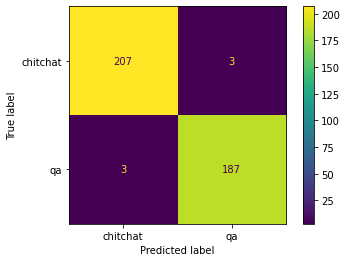

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = df['mode'].unique())
cm_display.plot()
plt.show()

## Fast text

In [ ]:
pred_fast = model.predict(ws_vec_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred, target_names=df['mode'].unique()))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = df['mode'].unique())
cm_display.plot()
plt.show()

# Sample Text for model prediction

In [ ]:
input_ = [input("Enter Some String Here: ")]
vec_test = ws_tfidf.transform(input_)
pred = clf.predict(vec_test)
print('results = ', df['mode'].unique()[pred])

## Prediction small test

In [ ]:
test_df = pd.read_csv('/content/small_test.csv')

In [ ]:
chit_test = pd.read_fwf('/content/chit.txt', header=None)
# data = pd.read_csv('/content/chit.txt', sep=" ", header=None)

## staking model

## test qa

In [ ]:
qa_test = test_df['question']

In [ ]:
vec_test = ws_tfidf.transform(qa_test)

In [ ]:
pred_qa = clf.predict(vec_test)

In [ ]:
df['mode'].unique()[pred_qa]

array(['qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa',
       'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa',
       'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa',
       'qa', 'qa', 'qa', 'chitchat', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa',
       'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa'], dtype=object)

In [ ]:
temp_dis = df['mode'].unique()[pred_qa]
for i in range(len(temp_dis)):
  if temp_dis[i] == 'chitchat':
    print(test_df.iloc[i])

id                            37
question    ดอกเบี้ยรับ มาจากไหน
Name: 36, dtype: object


## test chitchat

In [ ]:
chit_test.columns = ['question']

In [ ]:
qa_test = chit_test['question']

In [ ]:
vec_test = ws_tfidf.transform(qa_test)

In [ ]:
pred_qa = clf.predict(vec_test)

In [ ]:
df['mode'].unique()[pred_qa]

array(['chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'qa', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'qa', 'chitchat', 'chitchat',
       'qa', 'qa', 'qa', 'chitchat', 'chitchat', 'qa', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'qa', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'qa', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'qa', 'qa', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'chitchat', 'chitchat', 'chitchat',
       'chitchat', 'chitchat', 'qa', '

In [ ]:
temp_dis = df['mode'].unique()[pred_qa]
for i in range(len(temp_dis)):
  if temp_dis[i] == 'qa':
    print(chit_test.iloc[i])

question    ปลาตัวเล็กคืออะไร
Name: 0, dtype: object
question    วันนี้กินอะไรดี
Name: 1, dtype: object
question    นอนไม่หลับ ทำยังไงดี
Name: 2, dtype: object
question    แนะนำบอร์ดเกม น่าเล่นช่วงนี้หน่อย
Name: 3, dtype: object
question    แนะนำเกมออนไลน์เล่นกับเพื่อนหน่อย
Name: 4, dtype: object
question    ขอวิธีรวย โดยไม่ต้องทำงาน
Name: 5, dtype: object
question    นอนกี่ชั่วโมงดี ที่จะทำให้ร่างกายตื่นมาสดชื่น
Name: 6, dtype: object
question    ชอบหิวตอนดึกๆ แก้อย่างไรดี
Name: 7, dtype: object
question    วันหยุดยาวนี้ทำไรดี
Name: 8, dtype: object
question    อยากเก่งภาษาทำไงดี
Name: 9, dtype: object
question    เท่าไหร่
Name: 10, dtype: object
question    4Gหรือ2G?
Name: 11, dtype: object
question    เย็นกินไร
Name: 13, dtype: object
question    หมดวันไหน
Name: 14, dtype: object
question    เปนไงรสชาต
Name: 15, dtype: object
question    มีชีสมั้ยย
Name: 16, dtype: object
question    กี่บาทงะพี่
Name: 17, dtype: object
question    เคยเห็นมั้ย
Name: 18, dtype: object
question    นี่เ